# 標準化後轉為字串標記

In [1]:
import ast
import pandas as pd

def normalize_frozenset(x):
    if isinstance(x, str):
        try:
            content = x.replace("frozenset(", "").rstrip(")")
            # 處理單個元素時可能遺失逗號的問題
            if "'" in content and "," not in content:
                items = {content.strip("'")}
            else:
                items = ast.literal_eval(content)
            return sorted(list(items))
        except:
            return [x]
    elif isinstance(x, (frozenset, set)):
        return sorted(list(x))
    return [str(x)]

# 讀取資料
df = pd.read_csv('data/frequent_itemset/pre/association_rules_cluster11.csv')

# 1. 標準化並轉為字串標記
df['ante_list'] = df['antecedents'].apply(normalize_frozenset)
df['conse_list'] = df['consequents'].apply(normalize_frozenset)
df['ante_key'] = df['ante_list'].apply(lambda x: "_".join(x))
df['conse_key'] = df['conse_list'].apply(lambda x: "_".join(x))

# 數值型特徵: 畫出 Boxplot (箱型圖) 與 Histogram (直方圖)
1. Support (支持度) —— 極度稀疏的長尾
- 觀察：Boxplot 顯示盒子極度壓扁在底部（約 0.06 - 0.07），但上方有許多明顯的離群值點一直延伸到 0.14 以上。直方圖也顯示這是一個強烈的右偏分布。

- 意義：這代表絕大多數的地理座標關聯都是「偶發性」的（支持度低），只有極少數座標對是非常頻繁共現的。

- 對策：這驗證了我們之前的直覺，對於 Support 欄位，存入向量庫前建議進行 Log 轉換，否則那些高支持度的點會產生過大的主導力，讓 Agent 忽略了細微的地理關聯。

2. Confidence (置信度) —— 階梯式分布與強規則
- 觀察：直方圖呈現明顯的「多峰」且「階梯狀」分布，甚至在 1.0 (100%) 處有一個巨大的波峰。

- 意義：這是一個好現象！這說明你的數據中存在大量「絕對關聯」的規則（只要 A 發生，B 必定發生）。這對於 RAG 的知識庫來說是非常高品質的內容。

- 對策：在 RAG 的自然語言描述中，你可以針對 Confidence 接近 1.0 的條目，讓 LLM 使用更肯定的語氣（如：「具有絕對同步性」）。

3. Lift (提升度) —— 標準的常態偏態分布
- 觀察：Lift 主要集中在 6 到 10 之間，且只有極少數的離群值（Boxplot 最上方那個點）。

- 意義：這說明你的 Lift > 1.5 過濾門檻設得太寬鬆了。因為目前數據中最小的 Lift 似乎都在 2 以上。

- 對策：

    - 提高門檻：建議將門檻提高到 Lift > 5.0 甚至更高，這樣可以過濾掉大量平庸的規則，節省向量庫空間。

    - 無需過度縮放：比起 Support，Lift 的分布相對均勻，使用一般的標準化 (Standardization) 即可。

- 決策：這告訴您哪些特徵需要進行「Log Transform」或「Box-Cox」，否則計算餘弦相似度時，這些特徵會被忽略或造成誤導。

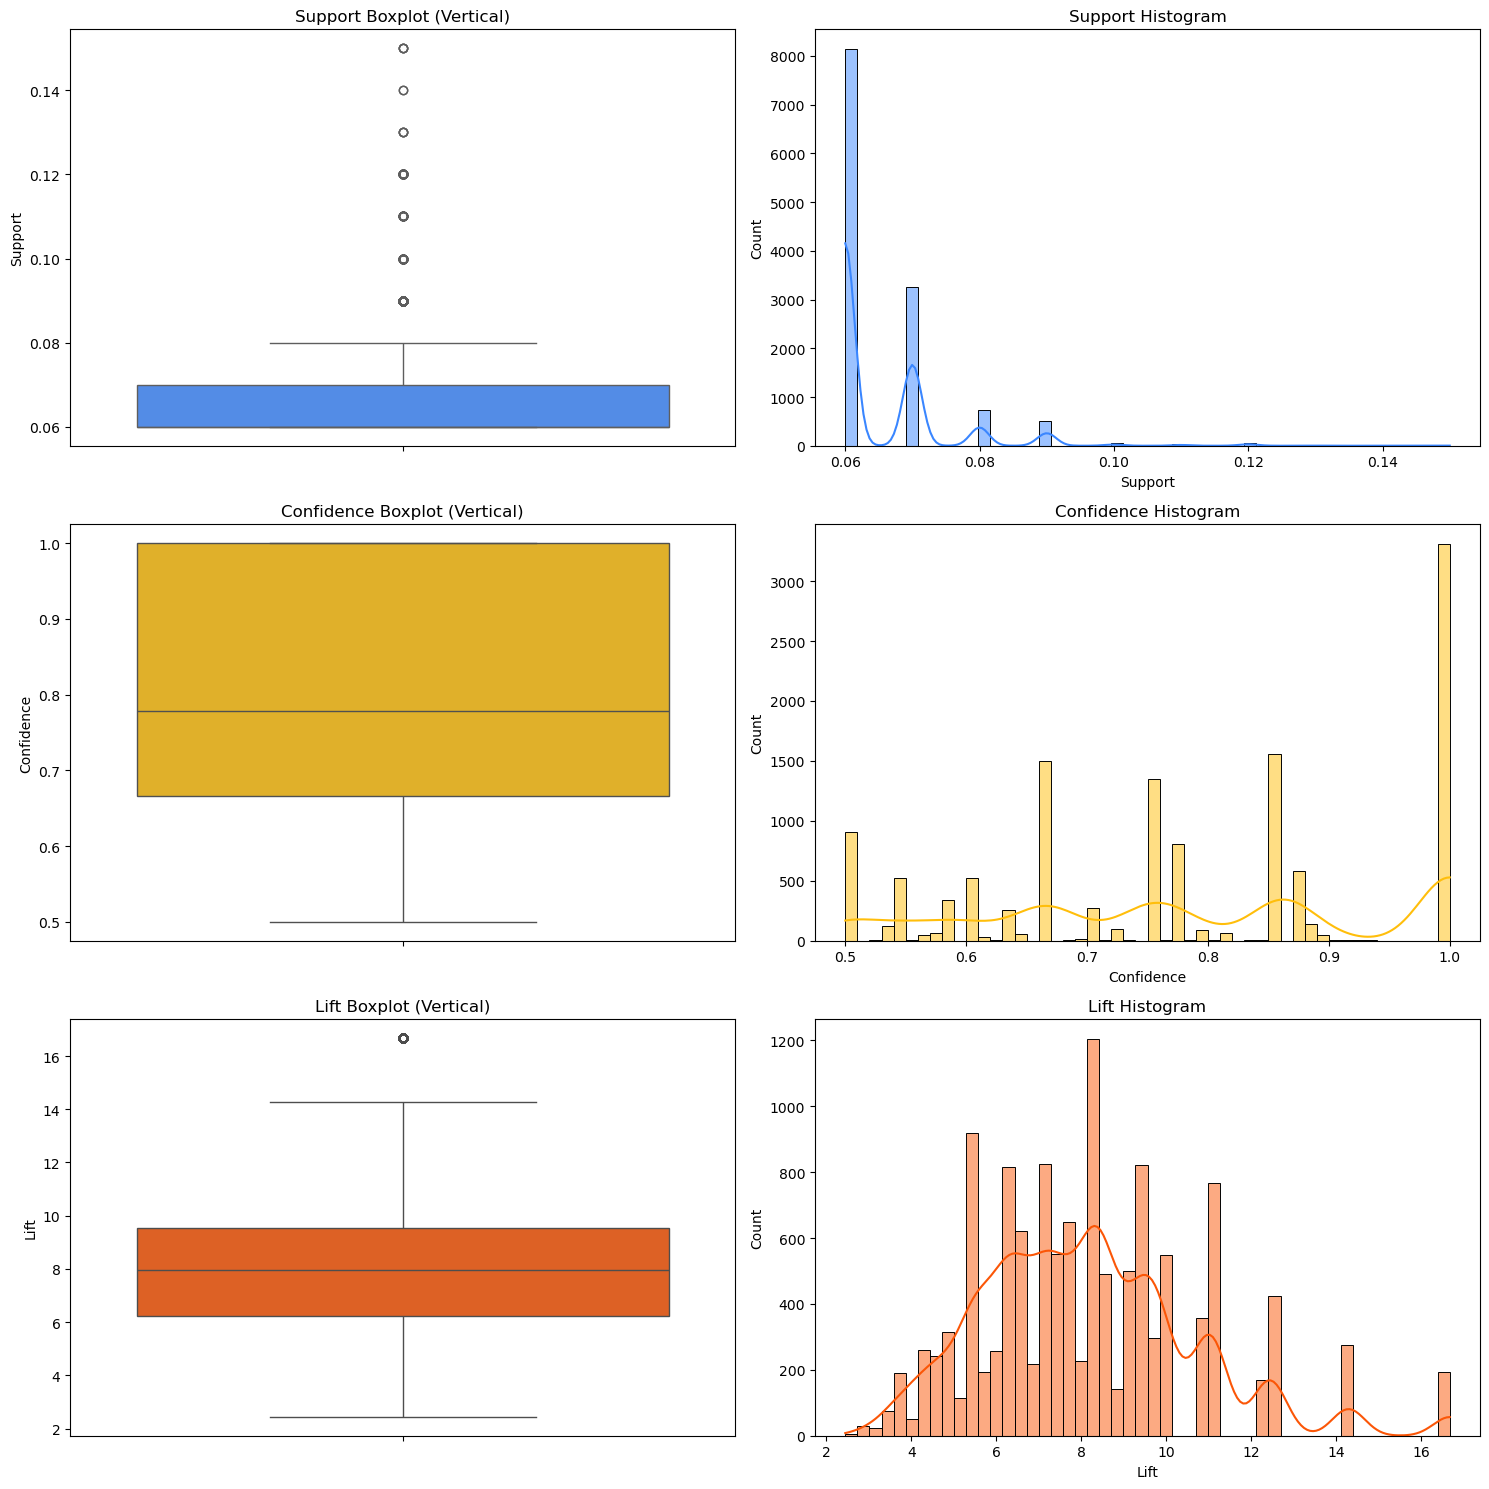

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定畫布大小 (3行 x 2列)
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

metrics = ['support', 'confidence', 'lift']
colors = ['#3a86ff', '#ffbe0b', '#fb5607']

for i, col in enumerate(metrics):
    # 左側：垂直 Boxplot (改為 y=...)
    sns.boxplot(y=df[col], ax=axes[i, 0], color=colors[i])
    axes[i, 0].set_title(f'{col.capitalize()} Boxplot (Vertical)', fontsize=12)
    axes[i, 0].set_ylabel(col.capitalize()) # 設定 Y 軸標籤
    
    # 右側：Histogram (顯示分布密度)
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i, 1], color=colors[i])
    axes[i, 1].set_title(f'{col.capitalize()} Histogram', fontsize=12)
    axes[i, 1].set_xlabel(col.capitalize())

plt.tight_layout()
plt.show()

1. support：Log 轉換 (使用 log(1+x))，如果不處理，少數高 Support 的座標點會像「黑洞」一樣吸走餘弦相似度的向量方向，導致 Agent 只會檢索到熱門座標，忽略了細微的關聯。

2. lift：標準化 (Standardization / Z-score)，雖然有極少數離群值，但整體接近常態分佈。這能確保 Lift 在餘弦計算中佔據對等的「發言權」。

3. confidence：Min-Max 縮放 (Min-Max Scaling)。這能完整保留原始數據中的比例關係。

# 類別型特徵: 計數圖 (Countplot) 或 長條圖 (Bar Plot)

C:\Users\user\AppData\Local\Temp\ipykernel_52992\4008519986.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ante.values, y=top_ante.index, ax=axes[0], palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_52992\4008519986.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_conse.values, y=top_conse.index, ax=axes[1], palette='magma')


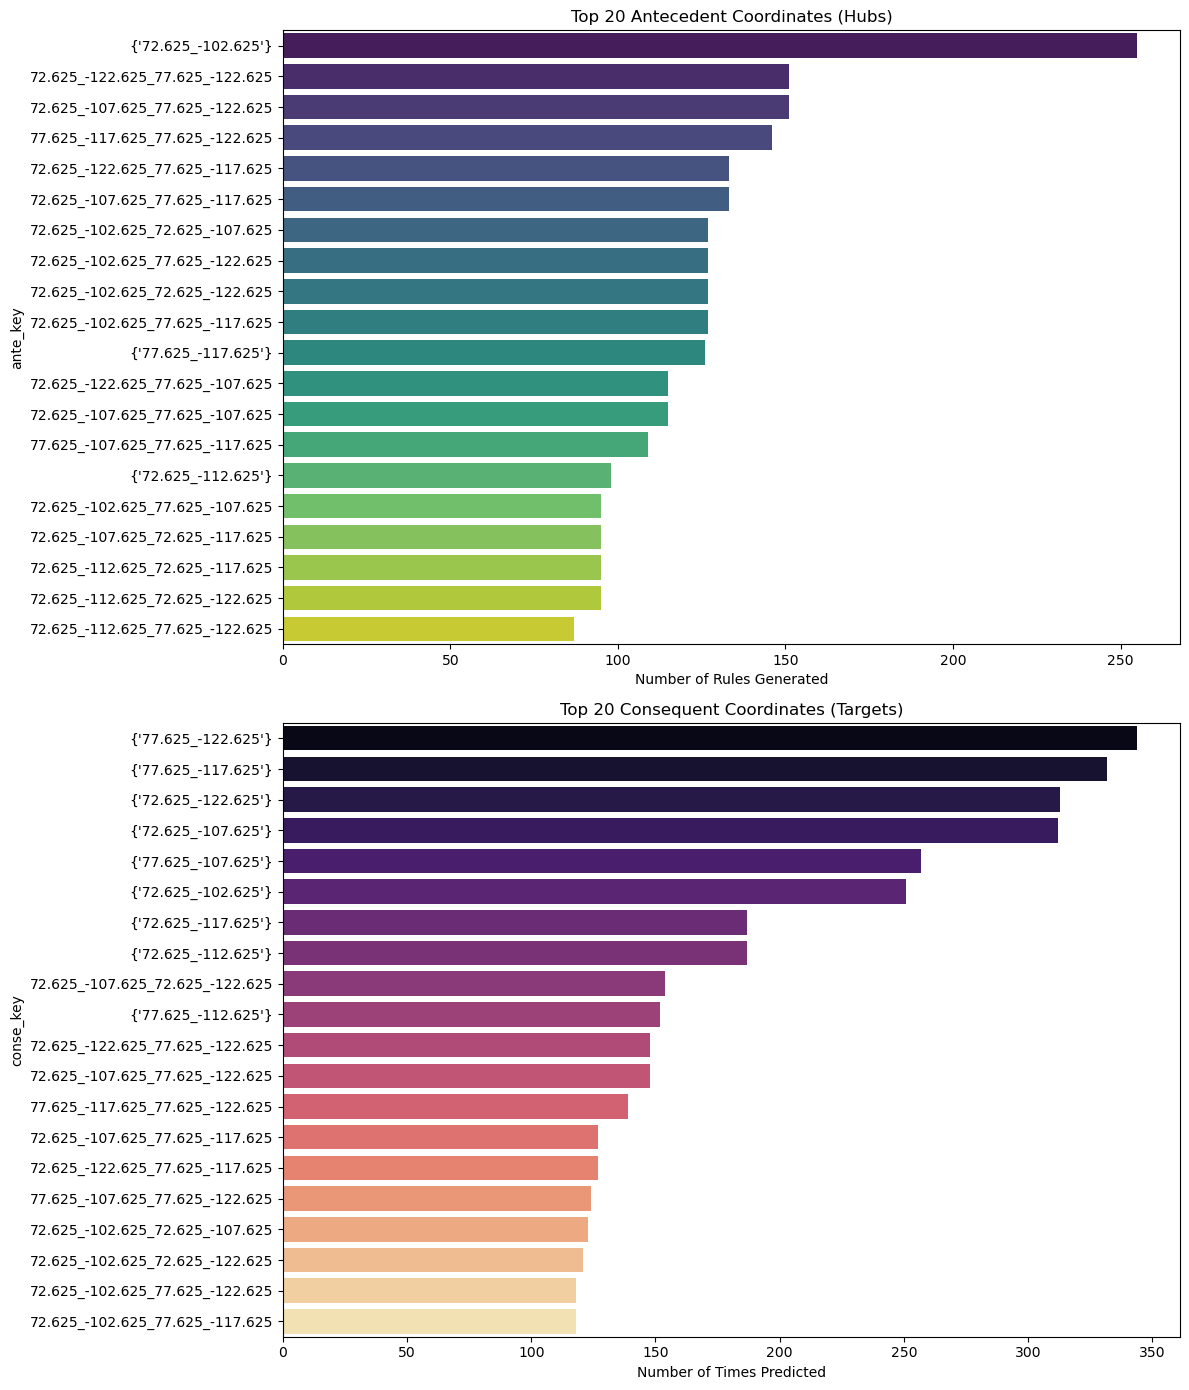

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定畫布
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# 1. 前項 (Antecedents) 最常出現的位置
top_ante = df['ante_key'].value_counts().head(20)
sns.barplot(x=top_ante.values, y=top_ante.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Antecedent Coordinates (Hubs)')
axes[0].set_xlabel('Number of Rules Generated')

# 2. 後項 (Consequents) 最常出現的位置
top_conse = df['conse_key'].value_counts().head(20)
sns.barplot(x=top_conse.values, y=top_conse.index, ax=axes[1], palette='magma')
axes[1].set_title('Top 20 Consequent Coordinates (Targets)')
axes[1].set_xlabel('Number of Times Predicted')

plt.tight_layout()
plt.show()

1. ante_key, conse_key計算規則間的「空間相似度」時，若跨越經度線，可以考慮將經緯度數值也轉為 sin/cos 週期編碼（cyclic encoding），輔助 Agent 判斷「物理距離」上的鄰近性。

2. 去重：針對產量前 20 的熱點座標限制儲存規則數。

# 做 Correlation Matrix (熱力圖) 分析特徵關聯

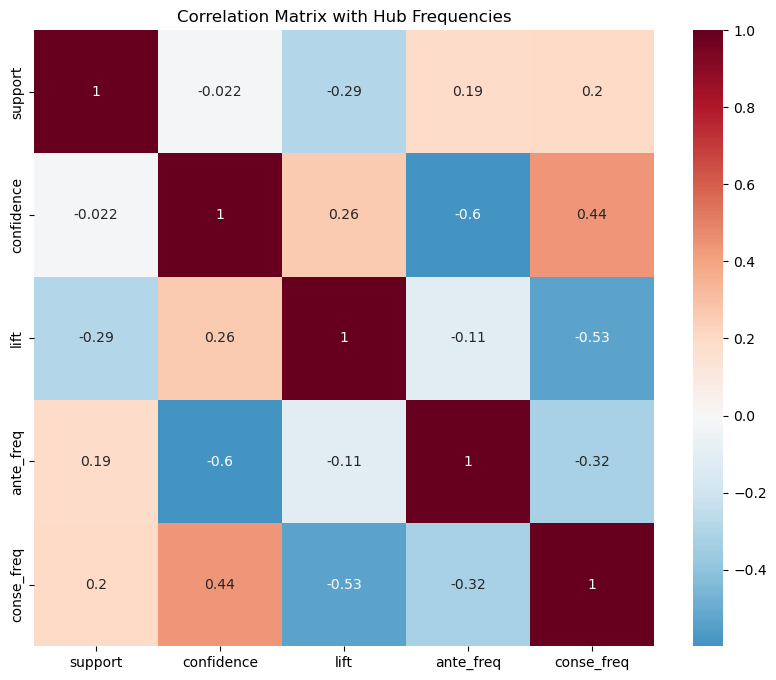

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 計算每個座標出現的頻率作為特徵
ante_counts = df['ante_key'].map(df['ante_key'].value_counts())
conse_counts = df['conse_key'].map(df['conse_key'].value_counts())

# 2. 建立用於分析的臨時 DataFrame
analysis_df = df[['support', 'confidence', 'lift']].copy()
analysis_df['ante_freq'] = ante_counts
analysis_df['conse_freq'] = conse_counts

# 3. 繪製熱力圖
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(analysis_df.corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation Matrix with Hub Frequencies')
plt.show()

1. 「熱點偏誤」的數據證據 (ante_freq vs confidence: -0.60)
發現：這是一個極強的負相關。代表當一個座標產生越多規則時（熱點），這些規則的 Confidence（可靠性）反而大幅下降。

原因：這通常是因為「熱點地區」什麼都有可能發生，導致關聯性被稀釋。

優化動作：這驗證了我們必須執行 「熱點去重」。對於這些高頻座標，我們不能只看數量，必須嚴格挑選那些即便在熱點區依然保持高 Confidence 的規則。

2. 「強度與普遍性」的權衡 (support vs lift: -0.29)
發現：兩者呈現負相關。代表「高提升度（強關聯）」的規則通常發生在「低支持度（較罕見）」的座標對中。

優化動作：這支持了對 Support 進行 Log 轉換 的必要性。如果不做轉換，餘弦相似度會過度偏向那些高 Support 但關聯強度（Lift）平庸的規則。

3. 「目標熱點」的特性 (conse_freq vs lift: -0.53)
發現：當一個座標經常作為「結果（Target）」出現時，它的關聯提升度（Lift）通常較低。

優化動作：這代表那些「大眾目標點」提供的地理洞察力較弱。在 RAG 檢索時，我們可以賦予那些 conse_freq 較低但 Lift 極高 的「精確預測規則」更高的語意權重。

# 1.資料預處理與特徵工程

目標：將原始 CSV 轉化為 RAG 可用的高品質向量與自然語言描述。

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. 指標縮放與座標週期編碼
def preprocess_features(df):
    """
    執行指標轉換、標準化以及地理座標的週期性編碼。
    """
    df = df.copy()

    # --- 1. 指標縮放 (與之前相同) ---
    df['support_log'] = np.log1p(df['support'])
    df['c_norm'] = MinMaxScaler().fit_transform(df[['confidence']])
    df[['s_norm', 'l_norm']] = StandardScaler().fit_transform(df[['support_log', 'lift']])

    # --- 2. 座標週期編碼函數 ---
    def encode_coords(coord_str):
        try:
            clean_str = str(coord_str).replace("{", "").replace("}", "").replace("'", "").replace(" ", "")
            lat_str, lon_str = clean_str.split('_')
            lat, lon = float(lat_str), float(lon_str)
            lon_rad = np.deg2rad(lon)
            return pd.Series([lat, np.sin(lon_rad), np.cos(lon_rad)])
        except:
            return pd.Series([np.nan, np.nan, np.nan])

    # --- 3. 同時對 Ante 和 Conse 進行編碼 ---
    # 前項 (Source)
    df[['ante_lat', 'ante_lon_sin', 'ante_lon_cos']] = df['ante_key'].apply(encode_coords)
    # 後項 (Target)
    df[['conse_lat', 'conse_lon_sin', 'conse_lon_cos']] = df['conse_key'].apply(encode_coords)
    
    # 剔除解析失敗的行
    df = df.dropna(subset=['ante_lat', 'conse_lat'])
    
    return df

# 2. 熱點冗餘控制 (Redundancy Control)
def filter_and_deduplicate(df, top_k_hubs=20):
    """
    過濾弱規則並針對熱點座標實施配額管理。
    """
    # 1. 過濾弱規則
    df_filtered = df[df['lift'] > 5.0].copy()

    # 2. 識別熱點
    top_hubs = df_filtered['ante_key'].value_counts().head(top_k_hubs).index

    # 3. 實施配額管理
    def apply_quota(group):
        # group.name 在 apply 中代表 groupby 的 key (也就是 ante_key)
        n = 3 if group.name in top_hubs else 5
        return group.sort_values('lift', ascending=False).head(n)

    # 修正：在某些 pandas 版本中，需要 reset_index 處理索引衝突
    return df_filtered.groupby('ante_key', group_keys=False).apply(apply_quota).reset_index(drop=True)

# --- 執行流程 ---
try:
    df_processed = preprocess_features(df)
    df_final = filter_and_deduplicate(df_processed)

    print(f"原始規則數: {len(df)}")
    print(f"特徵工程後規則數: {len(df_final)}")
    
    # 調整：檢視包含 Ante (Source) 與 Conse (Target) 的特徵
    print("\n### 最終特徵清單 (部分欄位) ###")
    check_cols = [
        'ante_key', 'conse_key', 
        's_norm', 'c_norm', 'l_norm', 
        'ante_lon_sin', 'ante_lon_cos', 
        'conse_lon_sin', 'conse_lon_cos'
    ]
    print(df_final[check_cols].head())
    
except KeyError as e:
    print(f"錯誤：找不到欄位 {e}。請檢查 CSV 是否正確讀取。")
except Exception as e:
    import traceback
    print(f"發生未預期錯誤：{e}")
    traceback.print_exc() # 建議加入這行，若發生錯誤能看到具體行數

原始規則數: 12771
特徵工程後規則數: 50

### 最終特徵清單 (部分欄位) ###
            ante_key          conse_key    s_norm    c_norm    l_norm  \
0  {'52.625_72.375'}  {'52.625_82.375'}  2.634623  0.200000 -1.054883   
1  {'52.625_77.375'}  {'52.625_82.375'}  4.735662  0.294118 -0.887028   
2  {'52.625_82.375'}  {'52.625_77.375'}  4.735662  1.000000 -0.887028   
3  {'52.625_82.375'}  {'52.625_72.375'}  2.634623  0.636364 -1.054883   
4  {'57.625_57.375'}  {'62.625_62.375'} -0.590347  0.500000  0.074642   

   ante_lon_sin  ante_lon_cos  conse_lon_sin  conse_lon_cos  
0      0.953059      0.302786       0.991158       0.132689  
1      0.975821      0.218569       0.991158       0.132689  
2      0.991158      0.132689       0.975821       0.218569  
3      0.991158      0.132689       0.953059       0.302786  
4      0.842217      0.539138       0.886001       0.463683  


C:\Users\user\AppData\Local\Temp\ipykernel_52992\1120963334.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_filtered.groupby('ante_key', group_keys=False).apply(apply_quota).reset_index(drop=True)


在關聯規則中，傳統的共現（Co-occurrence）是指兩個事件（或座標點）在原始數據中確實同時發生過。

真正的共現：數據顯示地點 A 出現時，地點 B 也出現了（例如：$A \to B$）。
偽共現（Pseudo-co-occurrence）：地點 A 與地點 C 在數據中從未同時出現，但因為 A 與 C 的特徵向量極其相似（例如：它們的地理環境、支持度分布、提升度水準幾乎一致），我們推論：「發生在 A 身上的規則，極大機率也會發生在 C 身上」。

為什麼稱為「偽」？
因為這種關係不是從「歷史行為」直接觀察到的，而是透過「特徵相似性」人工模擬出的連結。這能讓系統在沒有實際數據的情況下，預測出潛在的地理關聯。

- 為什麼要計算相似度矩陣？
計算 相似度矩陣（Similarity Matrix） 的主要目的，是為了在特徵空間中量化每一條規則或每一個地點之間的「親疏遠近」。

1. 解決「冷啟動」（Cold Start）問題
- 場景：當系統移至一個全新的地理區域，或者遇到一個全新的座標點時，資料庫中沒有關於它的共現紀錄。
- 解決：透過相似度矩陣，我們可以找到與新地點「特徵最像」的老地點，直接借用老地點的成熟規則來進行預測。
2. 數據補全與平滑（Data Smoothing）
- 場景：地理數據往往是片段的。可能地點 A 在 1 月份有數據，地點 C 在 2 月份才有。
- 解決：相似度矩陣將兩者連結起來。如果它們高度相似，系統會認為它們在時間與空間上具備「語義上的一致性」，從而消除採樣不足導致的斷層。
3. 實現「特徵驅動」的檢索
- 傳統搜尋是「精確匹配」（找 A 就是 A）；但有了矩陣後，可以實現**「模糊推理」**。當用戶詢問 A 時，Agent 可以根據相似度矩陣主動提供：「雖然 A 的資料不多，但與 A 特徵相似的 C 表現出了強烈的相關規律...」。

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# 1. 提取特徵矩陣 (包含處理後的指標與座標週期編碼)
feature_cols = [
    's_norm', 'c_norm', 'l_norm', 
    'ante_lat', 'ante_lon_sin', 'ante_lon_cos',
    'conse_lat', 'conse_lon_sin', 'conse_lon_cos'
]

# 2. 計算 Cosine Similarity Matrix
# 這會得到一個 N x N 的矩陣，代表每條規則與其他規則的相似度
sim_matrix = cosine_similarity(df_final[feature_cols])

def get_pseudo_cooccurrence(rule_index, top_n=5):
    """
    輸入一條規則的索引，回傳特徵最相似的其他規則（偽共現關係）。
    """
    # 取得該規則與所有人的相似分數
    sim_scores = list(enumerate(sim_matrix[rule_index]))
    
    # 排序並取出前 N 個 (排除自己)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    similar_indices = [i[0] for i in sim_scores[1:top_n+1]]
    
    return df_final.iloc[similar_indices]

In [14]:
import chromadb
from chromadb.utils import embedding_functions

def generate_semantic_text(row):
    # 1. 定義提升度等級 (關聯強度)
    lift_level = "極強" if row['lift'] > 10 else "顯著" if row['lift'] > 5 else "一般"
    
    # 2. 定義置信度等級 (發生機率的語義)
    # 這裡補上剛才遺漏的 conf_level 使用邏輯
    conf_level = "絕對同步發生" if row['confidence'] > 0.9 else "高機率同時觀測"
    
    # 3. 整合進最終文本
    # 透過文字描述，讓向量空間具備「機率感」與「強度感」
    text = (
        f"地理關聯規律：位置 {row['ante_key']} 與位置 {row['conse_key']} 存在{lift_level}的連結。 "
        f"根據數據，兩地表現出{conf_level}的特徵，"
        f"具體信心準則為 {row['confidence']:.1%}，提升度(Lift)達 {row['lift']:.2f}。"
    )
    return text

# 套用修正後的函數
df_final['rag_text'] = df_final.apply(generate_semantic_text, axis=1)

# 初始化 ChromaDB
client = chromadb.PersistentClient(path="./geo_rag_db")
collection = client.get_or_create_collection(name="geo_rules_cl11")

# 準備寫入數據
collection.add(
    ids=df_final.index.map(lambda x: f"rule_{x}").tolist(),
    documents=df_final['rag_text'].tolist(), # 您定義的語義文本
    metadatas=df_final[feature_cols].to_dict(orient='records') # 所有的特徵數值
)